# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

%matplotlib notebook

In [3]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [5]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /Septem/XPCS_SAXS_Multi_Run_Sep.ipynb


## Make a directory for saving results

In [6]:
CYCLE = '2016_2'
username = getpass.getuser()


date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [7]:

start_time, stop_time = '2016-08-14  23:01:00', '2016-08-14  23:31:00'  
#count : 1 ['8c9112'] (scan num: 126) (Measurement: PSPMMA1b 200C 50 x.002s 2s period_run_0_0 )

hdrs = db(start_time= start_time, stop_time = stop_time)
print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 12 uids are found
(137, 'f1a1d228-5b41-46ca-bd80-f6a51068a2a3', ['/XF11ID/data/2016/08/14/ab812a8a-118b-4537-a919_6247'])
(136, '008634cd-370b-4eb3-999a-ba096baa6ec4', ['/XF11ID/data/2016/08/14/880f2677-2434-4f12-8ec1_6246'])
(135, 'f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8', ['/XF11ID/data/2016/08/14/901c77e5-f0ad-4836-a30d_6245'])
(134, 'bef5e3ef-0667-4fb8-accb-636c8405d79a', ['/XF11ID/data/2016/08/14/5e6aba2d-29ec-4667-b927_6244'])
(133, '98738f52-d98a-4e05-b672-5c098fc8c35c', ['/XF11ID/data/2016/08/14/479febd2-da2b-4bb8-94b8_6243'])
(132, '5c5abc10-85f2-4982-9efb-9d100cc93d9a', ['/XF11ID/data/2016/08/14/267f4929-4b06-4819-b9c9_6242'])
(131, '1bf1ab81-9d39-48a9-b060-bd7ba10d6d06', ['/XF11ID/data/2016/08/14/9f91dbe5-6d02-4406-9ad5_6241'])
(130, '23f43e3c-c7f6-4e8a-8854-fb95b007ac56', ['/XF11ID/data/2016/08/14/2efcd701-798d-4d66-acb3_6240'])
(129, '80954628-c30a-4603-a7c0-746d61662485', ['/XF11ID/data/2016/08/14/89491e1b-8ce0-468e-9365_6239'])
(128, 'b308eaee-c3ca-4769-a537-fc748e8

In [8]:
uid_=  'PS205000-PMMA-207000-SMMA3-200C--Aug14' #give a meaningful folder name
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/


In [9]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/Average/


# Don't Change these lines below here

In [10]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  image
scan_id, full-uid, data path are:  126--8c91120c-ed88-47bc-9c75-d6ac694de77c--/XF11ID/data/2016/08/14/818b5346-0b47-4cc7-b4f4_6236


In [11]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/08/14/818b5346-0b47-4cc7-b4f4_6236_master.h5


In [12]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [13]:
imgs

<Frames>
Length: 49 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [14]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1346.0,
 'beam_center_y': 799.0,
 'count_time': 0.0020000001,
 'detector_distance': 4.8400002,
 'frame_time': 2.0,
 'incident_wavelength': 1.2853431,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [15]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly

#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

 
center = [   1331,1357  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))
center = [   1342, 1367  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.002 sec, Acquisition_period=2.0 sec
Beam center= [1367, 1342]


In [16]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [17]:
#setup_pargs

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [18]:

mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'Aug14_mask.npy' #>= 160 C use this one



<IPython.core.display.Javascript object>


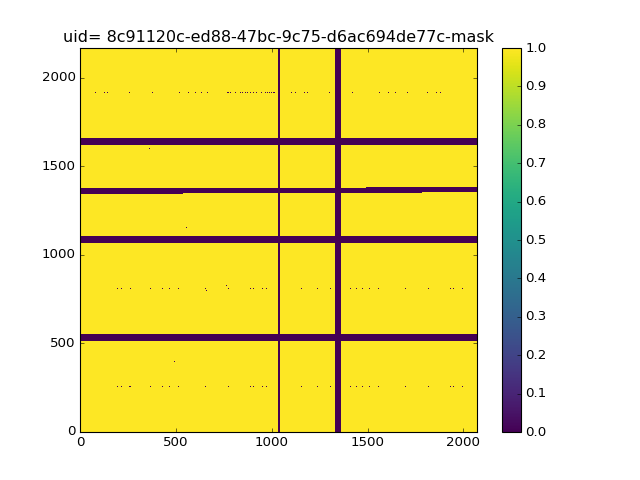

In [19]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [21]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [22]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


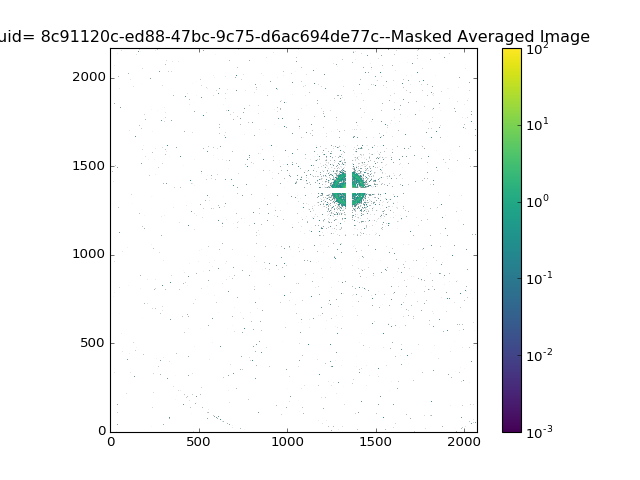

In [23]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


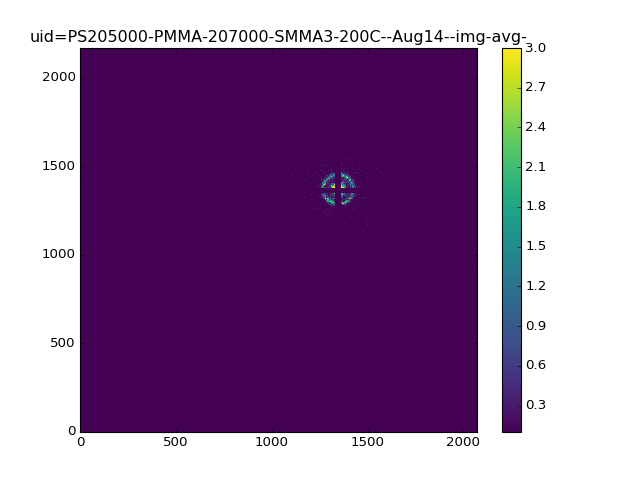

In [28]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


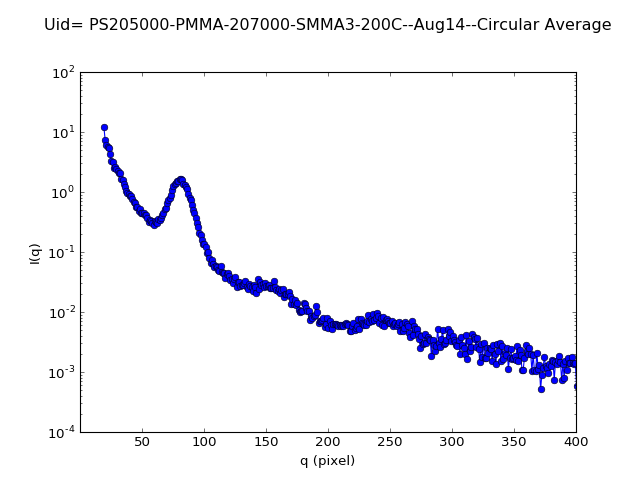

In [29]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
        plot_ = True, show_pixel= True,  ylim = [0.0001, 100] ,xlim=[0.01,400], save=True)

### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [30]:
uniform = False

### Define a non-uniform distributed rings by giving edges

In [31]:
if not uniform:
    
    width = 0.0002    
    number_rings=3    
    centers = [ 0.0061,0.012,0.018] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )   

    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [32]:
if uniform:
    inner_radius= 0.0058
    outer_radius = 0.018
    width = 0.0002
    num_rings = 9
    edges = None

In [33]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [34]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [35]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

<IPython.core.display.Javascript object>


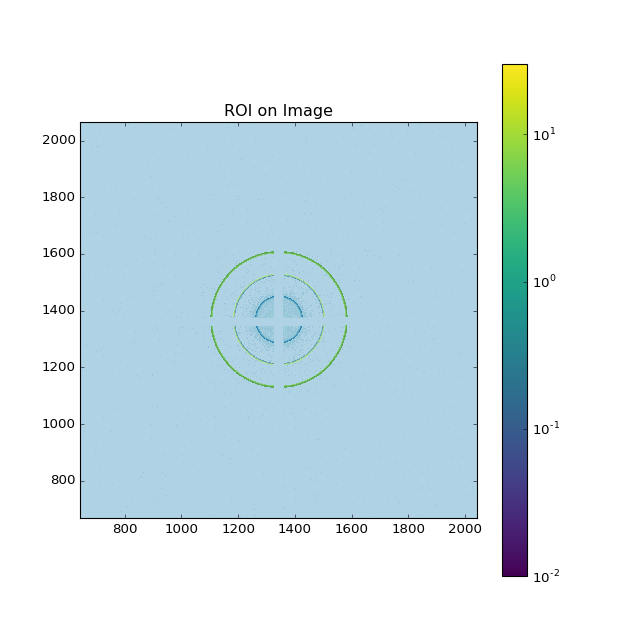

In [36]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=700, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

<IPython.core.display.Javascript object>


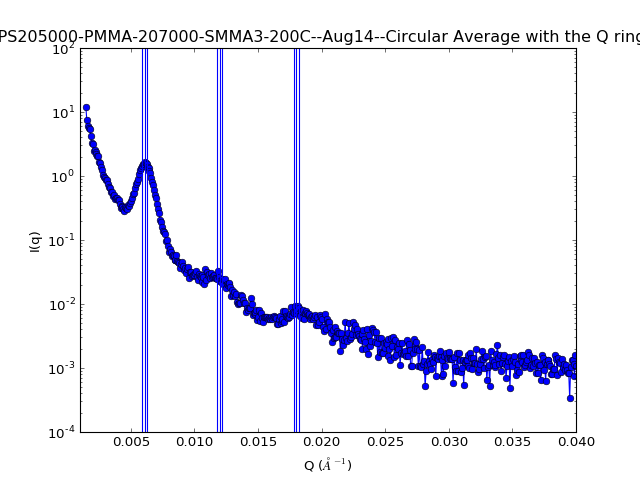

In [37]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid_,
                  ylim = [0.0001, 100] ,xlim=[0.001,.0400], save=True, path=data_dir_)

# Do loop here

In [40]:
run_num = 2
sub_num = 6

In [41]:
data_dir

'/XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/'

Get each frame intensity:   0%|          | 0/49 [00:00<?, ?it/s]

The 0--th uid to be analyzed is : 8c91120c-ed88-47bc-9c75-d6ac694de77c
hdf5 path = /XF11ID/data/2016/08/14/818b5346-0b47-4cc7-b4f4_6236_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_8c91120c-ed88-47bc-9c75-d6ac694de77c.cmp.


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3311.01it/s]


No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_0
With compression, the good_start frame number is: 2 


  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 349.29it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/8c91120c-ed88-47bc-9c75-d6ac694de77c/ with filename as uid=8c91120c-ed88-47bc-9c75-d6ac694de77c--g2.csv


<IPython.core.display.Javascript object>


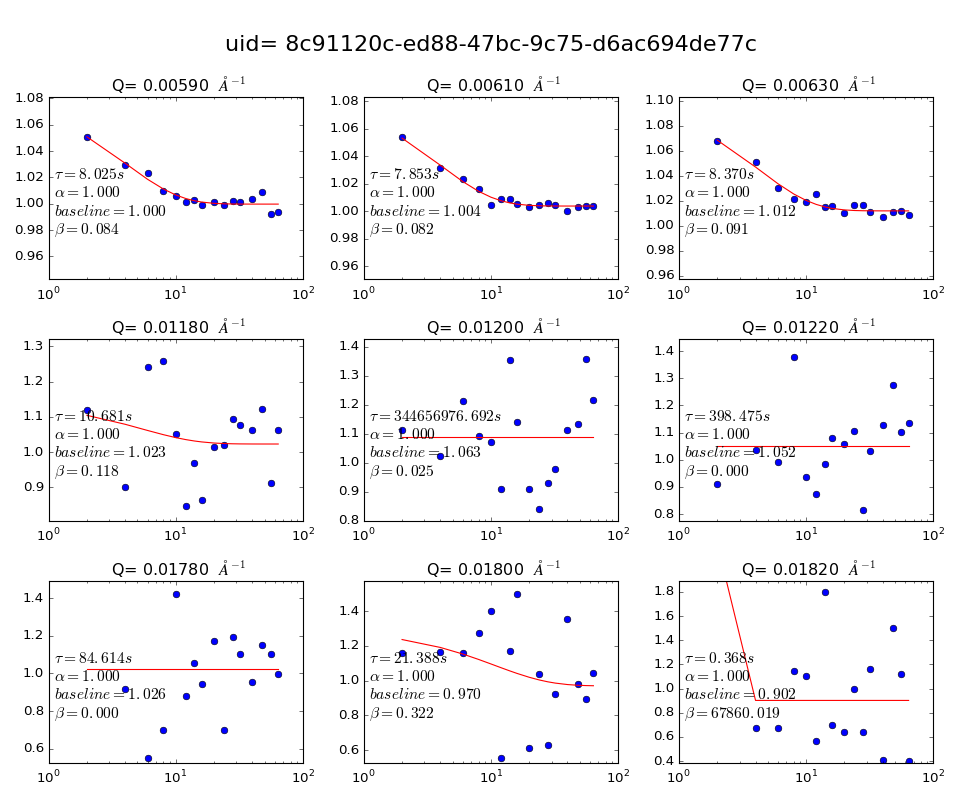

The fitted diffusion coefficient D0 is:  2.479e+03   A^2S-1


<IPython.core.display.Javascript object>


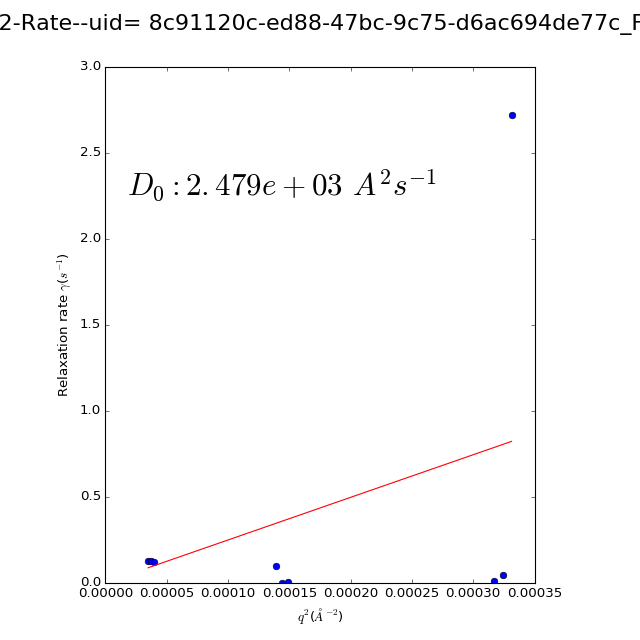

****************************************

The 1--th uid to be analyzed is : eeabe546-9550-49aa-842c-e698208fd214
hdf5 path = /XF11ID/data/2016/08/14/f02259bd-a47a-4ef2-854a_6237_master.h5


Averaging images:   0%|          | 0/49 [00:00<?, ?it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_eeabe546-9550-49aa-842c-e698208fd214.cmp.


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3463.45it/s]


No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_1
With compression, the good_start frame number is: 2 


  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 356.56it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/eeabe546-9550-49aa-842c-e698208fd214/ with filename as uid=eeabe546-9550-49aa-842c-e698208fd214--g2.csv


<IPython.core.display.Javascript object>


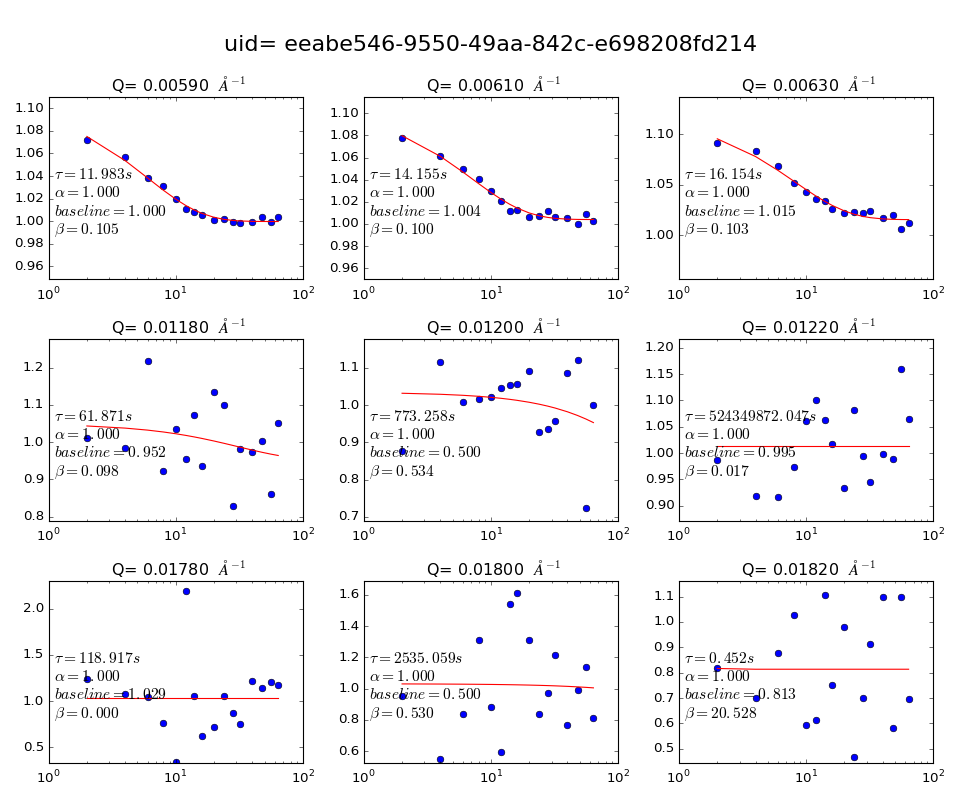

The fitted diffusion coefficient D0 is:  1.956e+03   A^2S-1


<IPython.core.display.Javascript object>


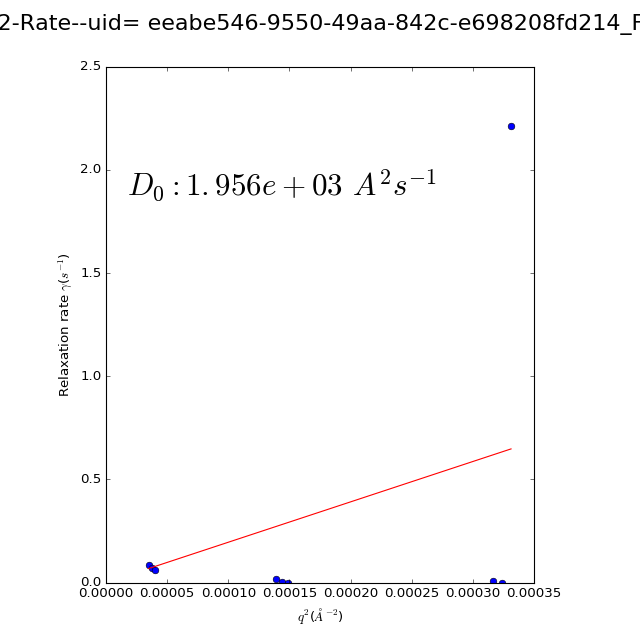

****************************************

The 2--th uid to be analyzed is : b308eaee-c3ca-4769-a537-fc748e8e5d5c
hdf5 path = /XF11ID/data/2016/08/14/1b9cee8a-77cc-4384-9cd4_6238_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3343.60it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_b308eaee-c3ca-4769-a537-fc748e8e5d5c.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_2
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 366.85it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/b308eaee-c3ca-4769-a537-fc748e8e5d5c/ with filename as uid=b308eaee-c3ca-4769-a537-fc748e8e5d5c--g2.csv


<IPython.core.display.Javascript object>


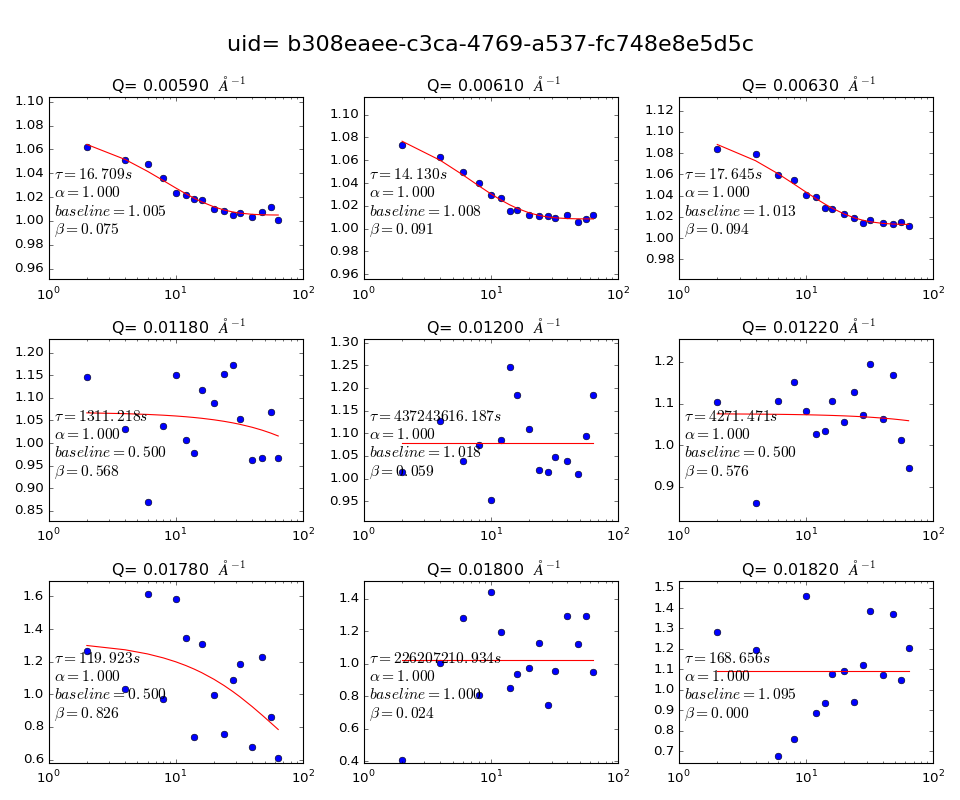

The fitted diffusion coefficient D0 is:  3.070e+01   A^2S-1


<IPython.core.display.Javascript object>


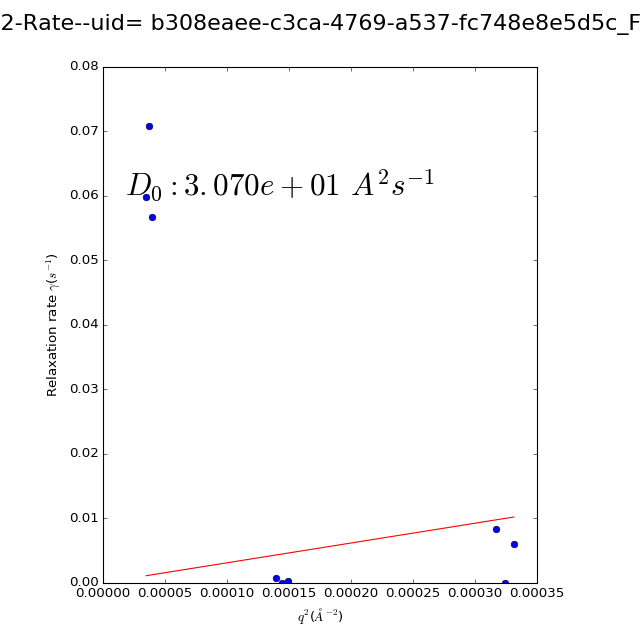

****************************************

The 3--th uid to be analyzed is : 80954628-c30a-4603-a7c0-746d61662485
hdf5 path = /XF11ID/data/2016/08/14/89491e1b-8ce0-468e-9365_6239_master.h5


Get each frame intensity:   0%|          | 0/49 [00:00<?, ?it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_80954628-c30a-4603-a7c0-746d61662485.cmp.


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3151.44it/s]


No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_3
With compression, the good_start frame number is: 2 


  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 163.53it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/80954628-c30a-4603-a7c0-746d61662485/ with filename as uid=80954628-c30a-4603-a7c0-746d61662485--g2.csv


<IPython.core.display.Javascript object>


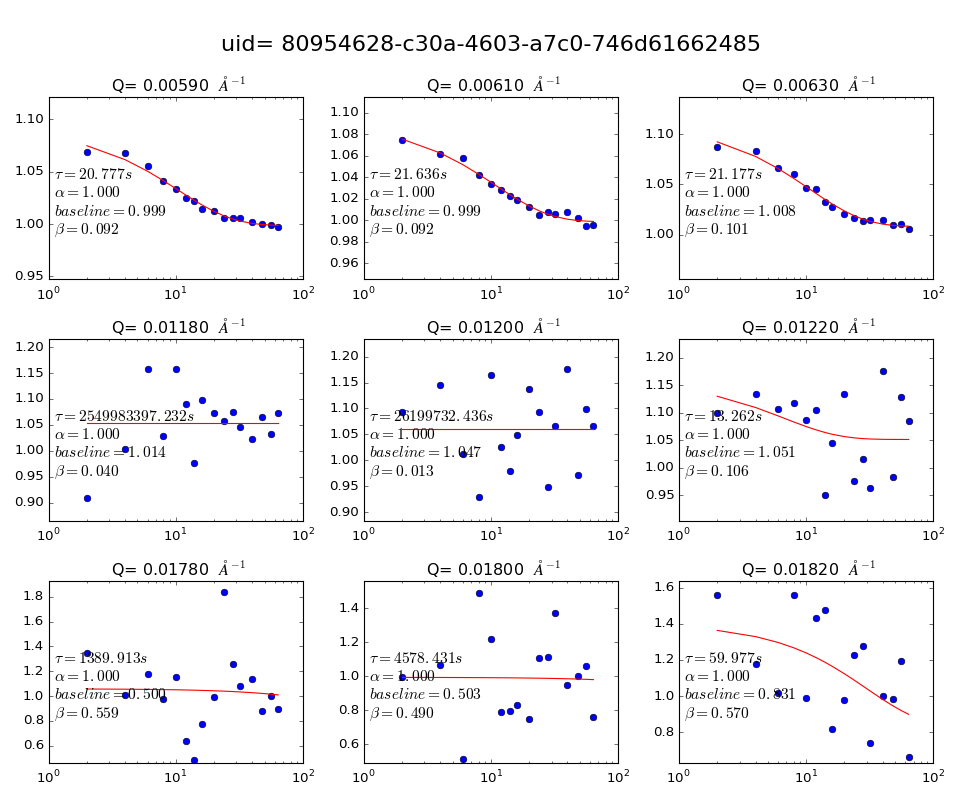

The fitted diffusion coefficient D0 is:  5.849e+01   A^2S-1


<IPython.core.display.Javascript object>


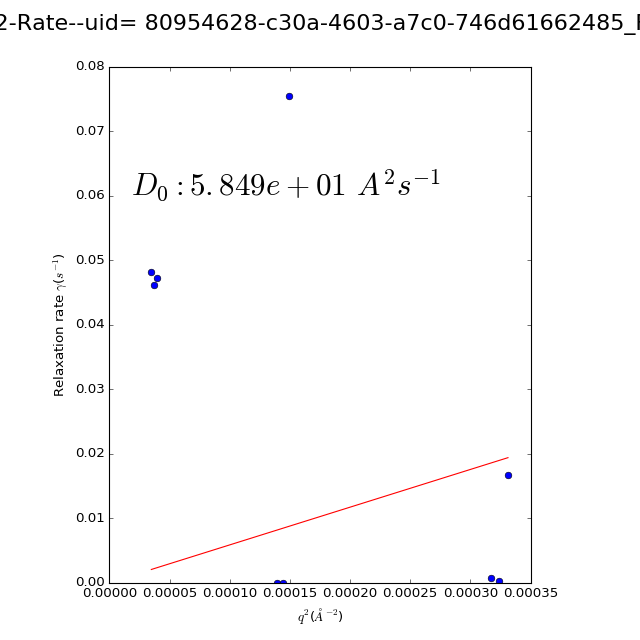

****************************************

The 4--th uid to be analyzed is : 23f43e3c-c7f6-4e8a-8854-fb95b007ac56
hdf5 path = /XF11ID/data/2016/08/14/2efcd701-798d-4d66-acb3_6240_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3774.84it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_23f43e3c-c7f6-4e8a-8854-fb95b007ac56.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_4
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 361.03it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/23f43e3c-c7f6-4e8a-8854-fb95b007ac56/ with filename as uid=23f43e3c-c7f6-4e8a-8854-fb95b007ac56--g2.csv


<IPython.core.display.Javascript object>


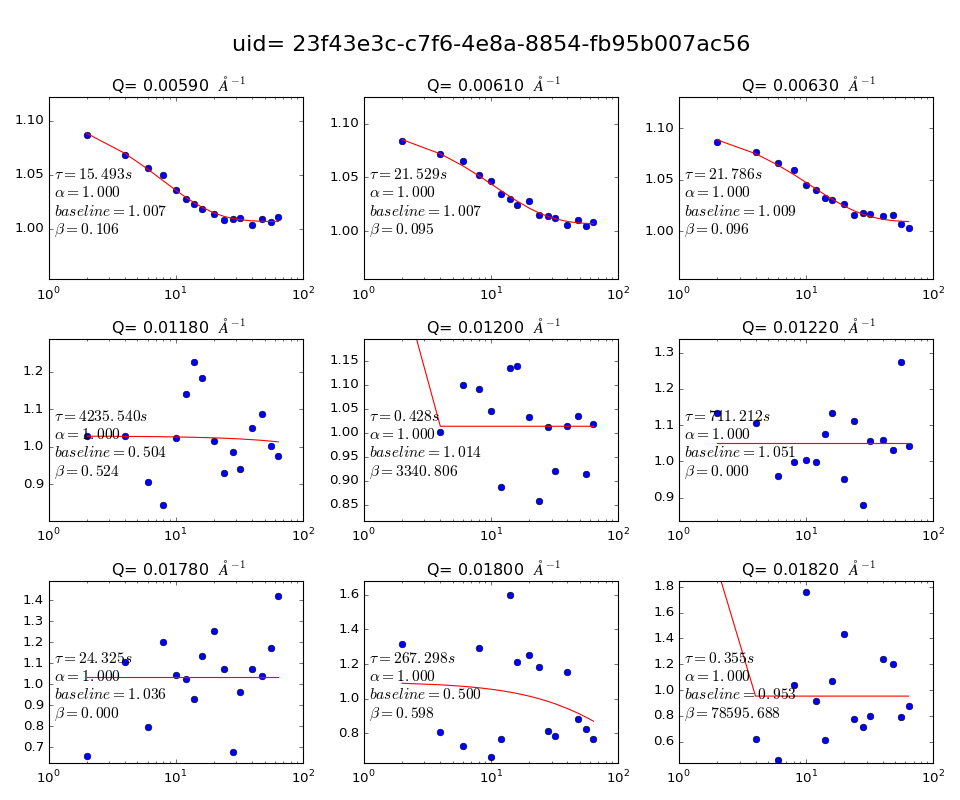

The fitted diffusion coefficient D0 is:  3.384e+03   A^2S-1


<IPython.core.display.Javascript object>


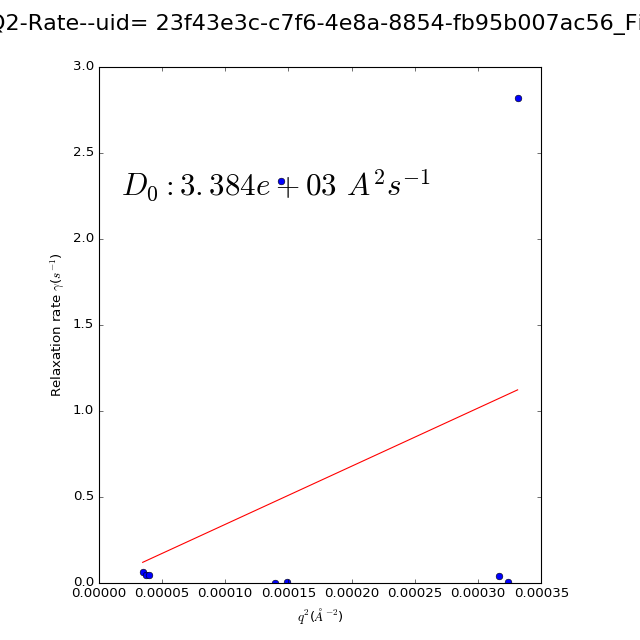

****************************************

The 5--th uid to be analyzed is : 1bf1ab81-9d39-48a9-b060-bd7ba10d6d06
hdf5 path = /XF11ID/data/2016/08/14/9f91dbe5-6d02-4406-9ad5_6241_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3261.46it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_1bf1ab81-9d39-48a9-b060-bd7ba10d6d06.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_0_5
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 346.53it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/1bf1ab81-9d39-48a9-b060-bd7ba10d6d06/ with filename as uid=1bf1ab81-9d39-48a9-b060-bd7ba10d6d06--g2.csv


<IPython.core.display.Javascript object>


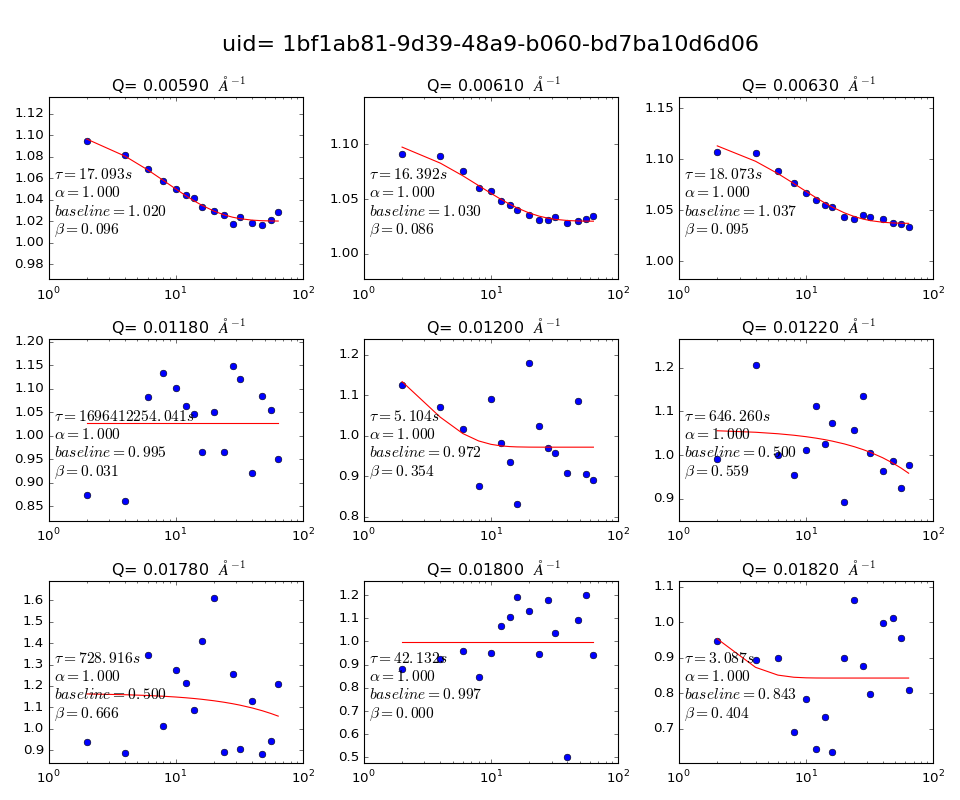

The fitted diffusion coefficient D0 is:  3.941e+02   A^2S-1


<IPython.core.display.Javascript object>


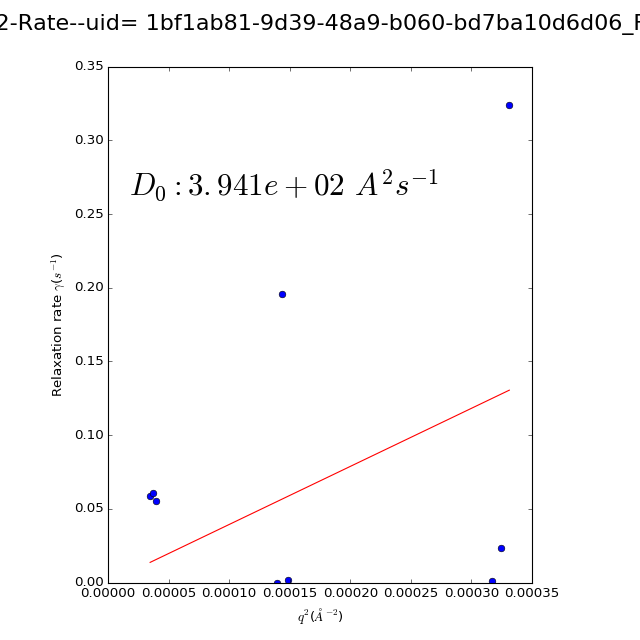

****************************************

The 0--th uid to be analyzed is : 5c5abc10-85f2-4982-9efb-9d100cc93d9a
hdf5 path = /XF11ID/data/2016/08/14/267f4929-4b06-4819-b9c9_6242_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3750.24it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_5c5abc10-85f2-4982-9efb-9d100cc93d9a.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_1_0
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 350.27it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/5c5abc10-85f2-4982-9efb-9d100cc93d9a/ with filename as uid=5c5abc10-85f2-4982-9efb-9d100cc93d9a--g2.csv


<IPython.core.display.Javascript object>


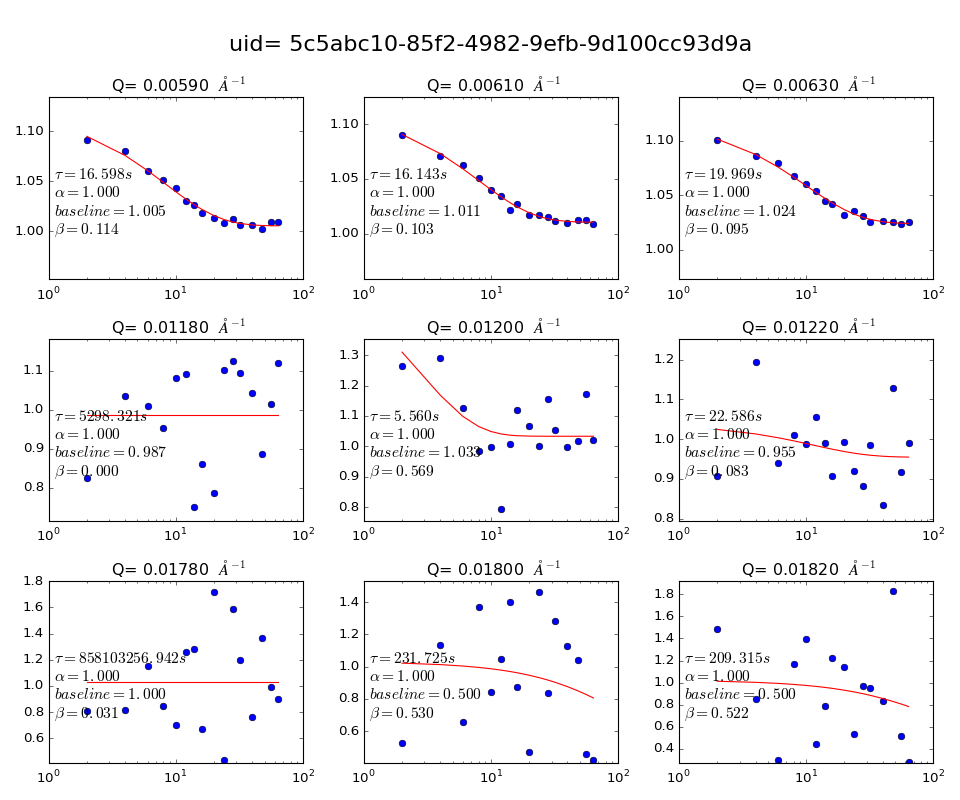

The fitted diffusion coefficient D0 is:  1.098e+02   A^2S-1


<IPython.core.display.Javascript object>


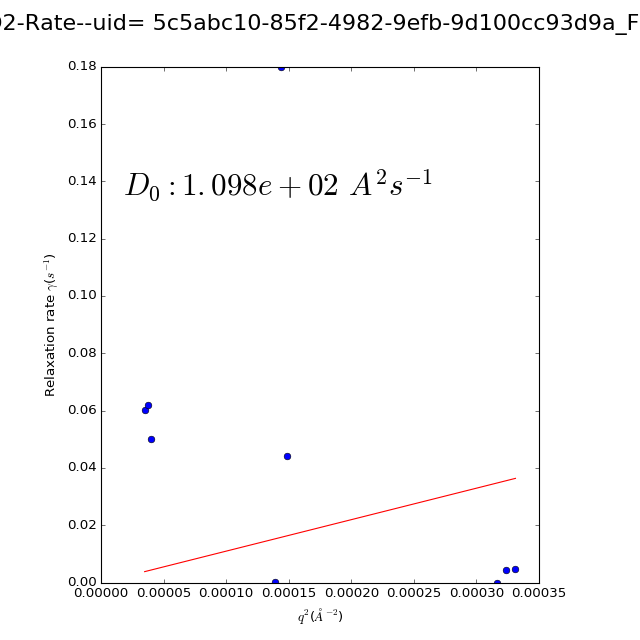

****************************************

The 1--th uid to be analyzed is : 98738f52-d98a-4e05-b672-5c098fc8c35c
hdf5 path = /XF11ID/data/2016/08/14/479febd2-da2b-4bb8-94b8_6243_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3797.01it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_98738f52-d98a-4e05-b672-5c098fc8c35c.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_1_1
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 351.71it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/98738f52-d98a-4e05-b672-5c098fc8c35c/ with filename as uid=98738f52-d98a-4e05-b672-5c098fc8c35c--g2.csv


<IPython.core.display.Javascript object>


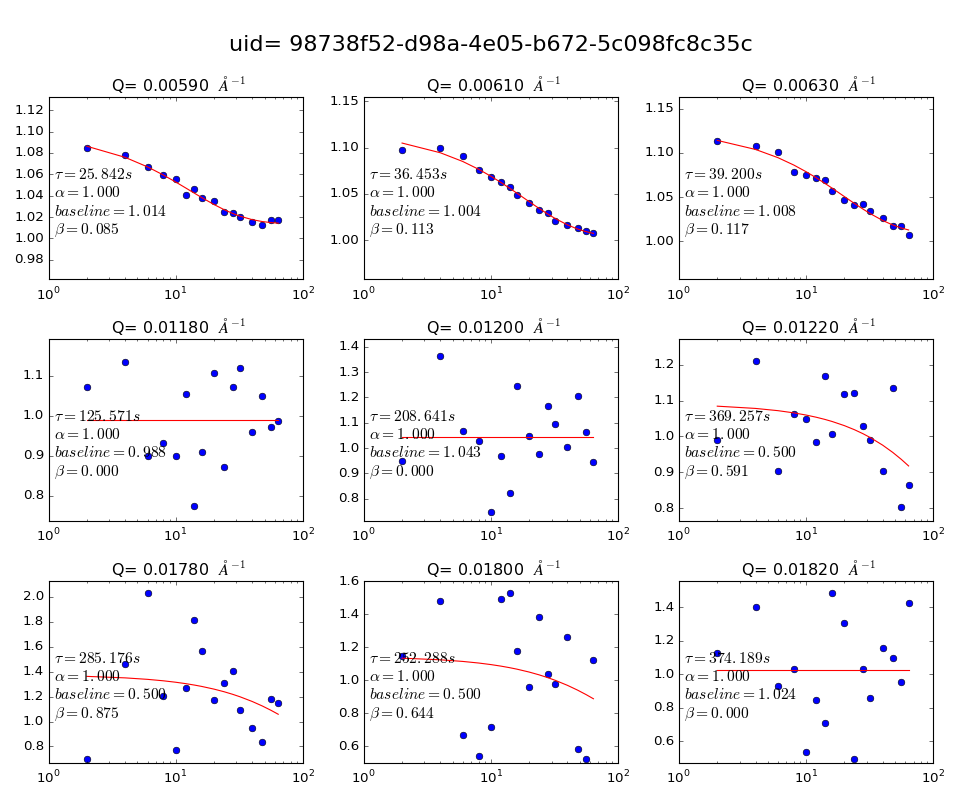

The fitted diffusion coefficient D0 is:  2.323e+01   A^2S-1


<IPython.core.display.Javascript object>


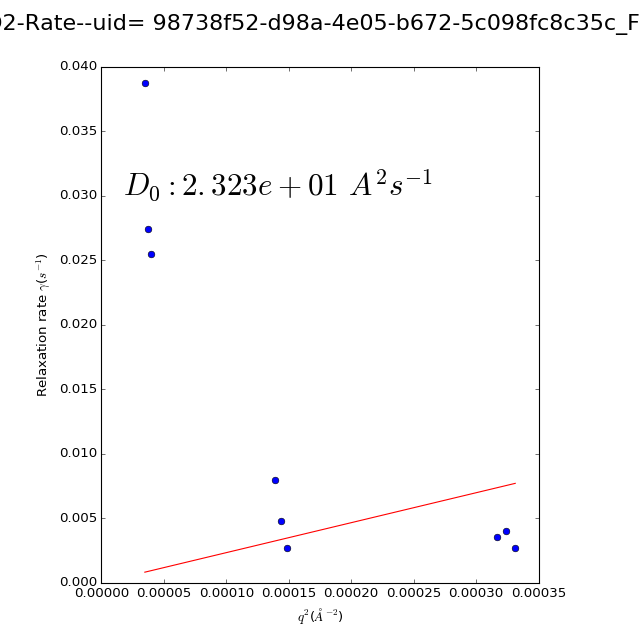

****************************************

The 2--th uid to be analyzed is : bef5e3ef-0667-4fb8-accb-636c8405d79a
hdf5 path = /XF11ID/data/2016/08/14/5e6aba2d-29ec-4667-b927_6244_master.h5
Trying again ...!
hdf5 path = /XF11ID/data/2016/08/14/5e6aba2d-29ec-4667-b927_6244_master.h5
Can't Load Data!
The 3--th uid to be analyzed is : f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8
hdf5 path = /XF11ID/data/2016/08/14/901c77e5-f0ad-4836-a30d_6245_master.h5


Get each frame intensity:   0%|          | 0/49 [00:00<?, ?it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8.cmp.


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3053.03it/s]


No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_1_3
With compression, the good_start frame number is: 2 


  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 350.39it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8/ with filename as uid=f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8--g2.csv


<IPython.core.display.Javascript object>


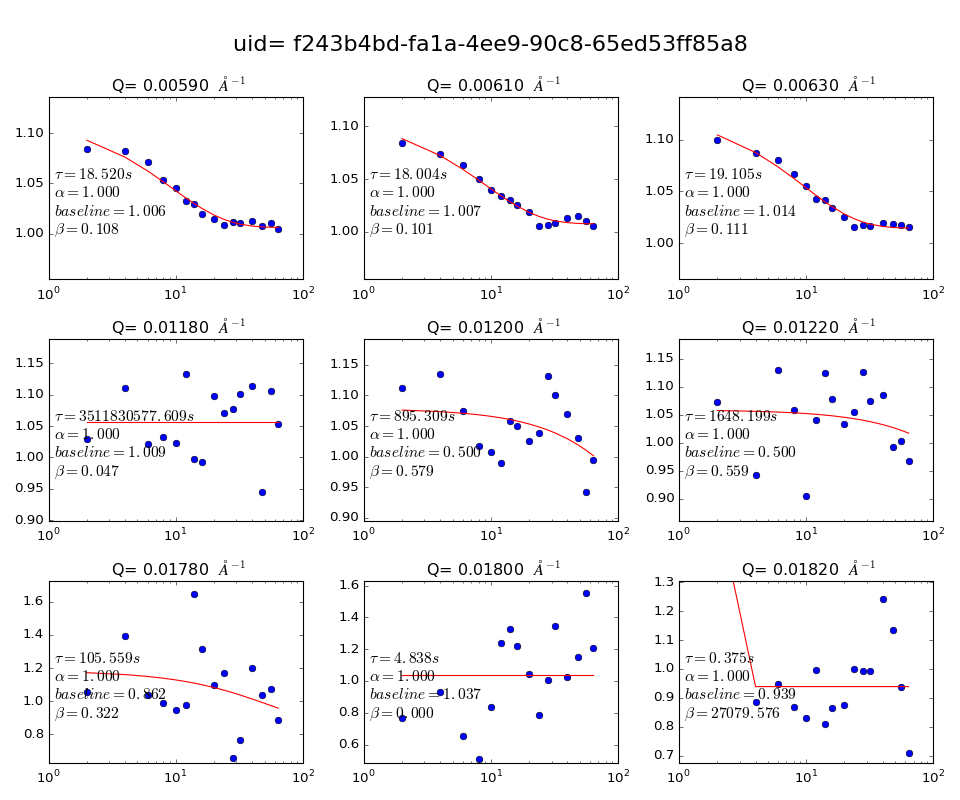

The fitted diffusion coefficient D0 is:  2.517e+03   A^2S-1


<IPython.core.display.Javascript object>


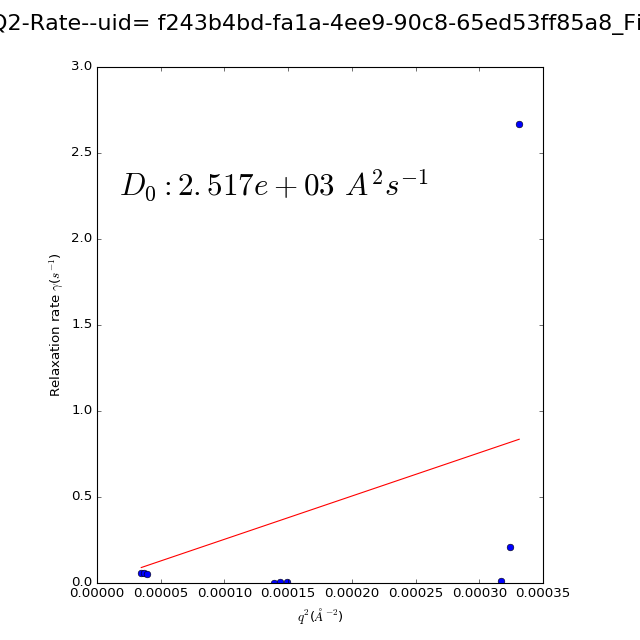

****************************************

The 4--th uid to be analyzed is : 008634cd-370b-4eb3-999a-ba096baa6ec4
hdf5 path = /XF11ID/data/2016/08/14/880f2677-2434-4f12-8ec1_6246_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3571.17it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_008634cd-370b-4eb3-999a-ba096baa6ec4.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_1_4
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 362.08it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/008634cd-370b-4eb3-999a-ba096baa6ec4/ with filename as uid=008634cd-370b-4eb3-999a-ba096baa6ec4--g2.csv


<IPython.core.display.Javascript object>


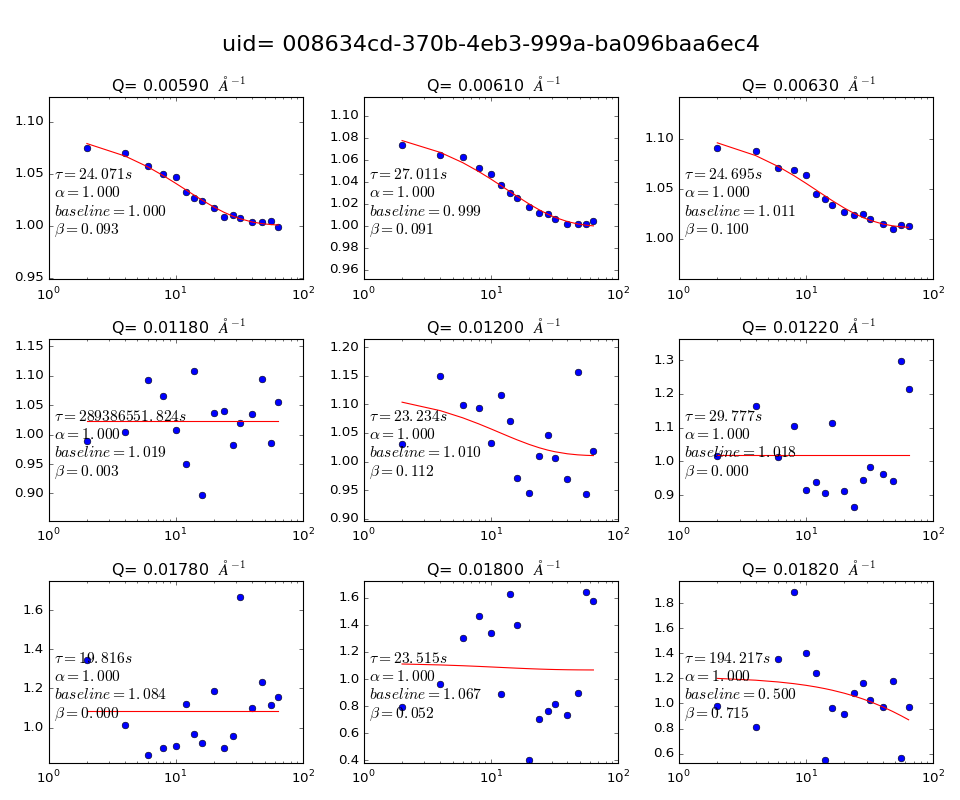

The fitted diffusion coefficient D0 is:  1.234e+02   A^2S-1


<IPython.core.display.Javascript object>


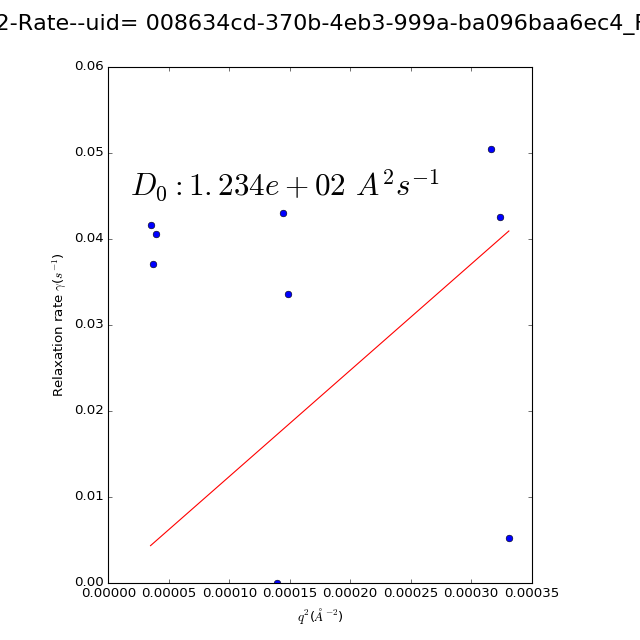

****************************************

The 5--th uid to be analyzed is : f1a1d228-5b41-46ca-bd80-f6a51068a2a3
hdf5 path = /XF11ID/data/2016/08/14/ab812a8a-118b-4537-a919_6247_master.h5


Get each frame intensity: 100%|██████████| 49/49 [00:00<00:00, 3467.36it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_f1a1d228-5b41-46ca-bd80-f6a51068a2a3.cmp.
No bad frames are involved.
PSPMMA1b 200C 50 x.002s 2s period_run_1_5
With compression, the good_start frame number is: 2 



  0%|          | 0/47 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--4--
47 frames will be processed...


100%|██████████| 47/47 [00:00<00:00, 360.71it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/f1a1d228-5b41-46ca-bd80-f6a51068a2a3/ with filename as uid=f1a1d228-5b41-46ca-bd80-f6a51068a2a3--g2.csv


<IPython.core.display.Javascript object>


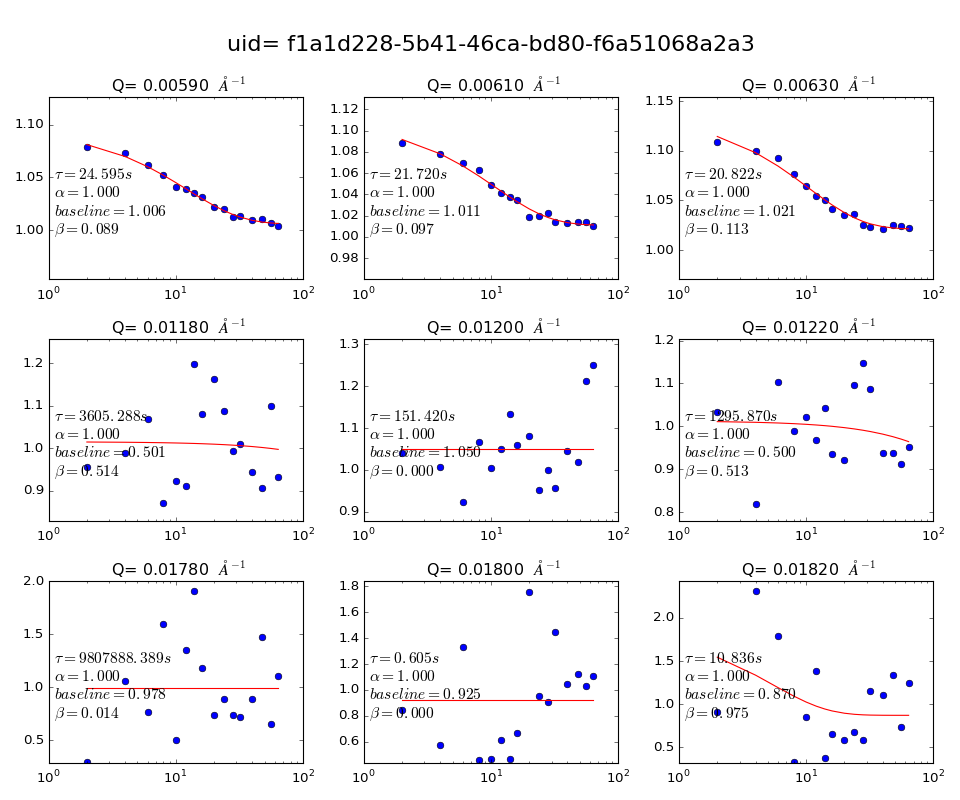

The fitted diffusion coefficient D0 is:  1.500e+03   A^2S-1


<IPython.core.display.Javascript object>


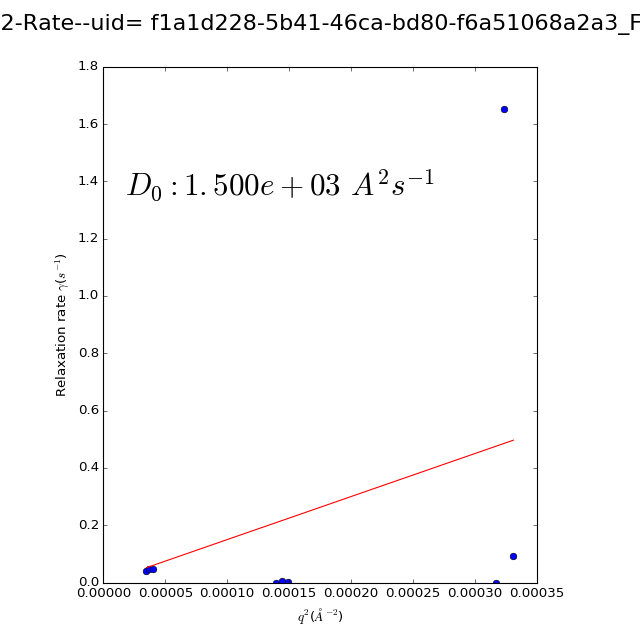

****************************************



In [43]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, fit= True, compress=True  )


## Create PDF report for each uid

In [47]:
useful_uids

{1: {1: '8c91120c-ed88-47bc-9c75-d6ac694de77c',
  2: 'eeabe546-9550-49aa-842c-e698208fd214',
  3: 'b308eaee-c3ca-4769-a537-fc748e8e5d5c',
  4: '80954628-c30a-4603-a7c0-746d61662485',
  5: '23f43e3c-c7f6-4e8a-8854-fb95b007ac56',
  6: '1bf1ab81-9d39-48a9-b060-bd7ba10d6d06'},
 2: {1: '5c5abc10-85f2-4982-9efb-9d100cc93d9a',
  2: '98738f52-d98a-4e05-b672-5c098fc8c35c',
  4: 'f243b4bd-fa1a-4ee9-90c8-65ed53ff85a8',
  5: '008634cd-370b-4eb3-999a-ba096baa6ec4',
  6: 'f1a1d228-5b41-46ca-bd80-f6a51068a2a3'}}

* Create multi PDF report for each uid

In [45]:
#create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir )

## Create one PDF including all uids

In [46]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/XPCS_Analysis_Report_for_uid=PS205000-PMMA-207000-SMMA3-200C--Aug14.pdf
****************************************


# Do average Here

In [48]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            g2s_average[key] +=  g2s[key][sub_key]
            i +=1
            print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
            #print( 'sub= %s,Doing average here'%sub_key)
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
Run= 1--sub_run= 5-- pass
Run= 1--sub_run= 6-- pass
Run= 2--sub_run= 1-- pass
Run= 2--sub_run= 2-- pass
Run= 2--sub_run= 4-- pass
Run= 2--sub_run= 5-- pass
Run= 2--sub_run= 6-- pass


# Save Data

In [49]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/Average/ with filename as uid=PS205000-PMMA-207000-SMMA3-200C--Aug14@run--1--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_2/yuzhang/Results/PS205000-PMMA-207000-SMMA3-200C--Aug14/Average/ with filename as uid=PS205000-PMMA-207000-SMMA3-200C--Aug14@run--2--g2.csv


# Plot All the g2 Data

In [50]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Avergaed Data

In [51]:
if False:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [52]:
fit = True

<IPython.core.display.Javascript object>


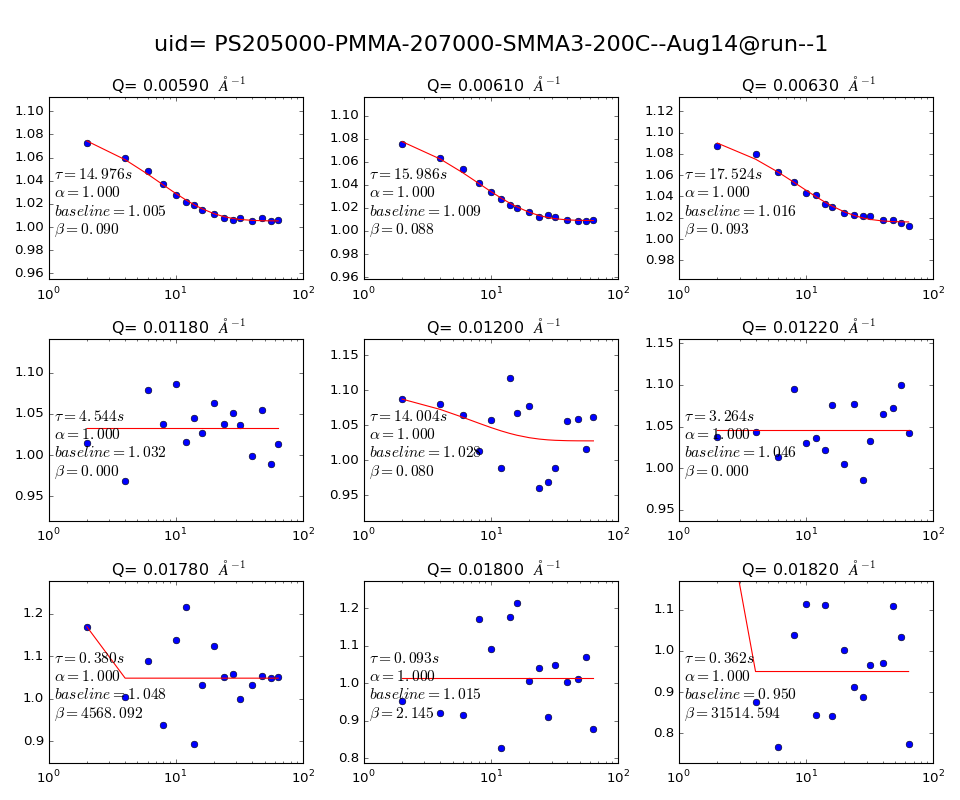

The fitted diffusion coefficient D0 is:  1.393e+04   A^2S-1


<IPython.core.display.Javascript object>


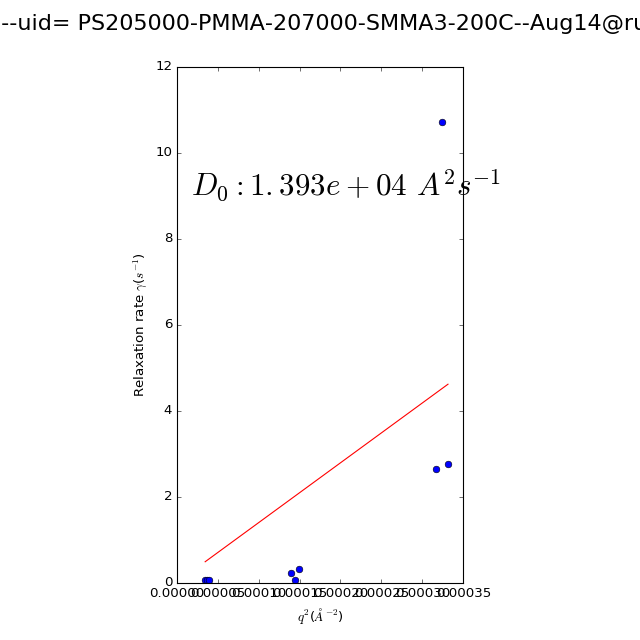

<IPython.core.display.Javascript object>


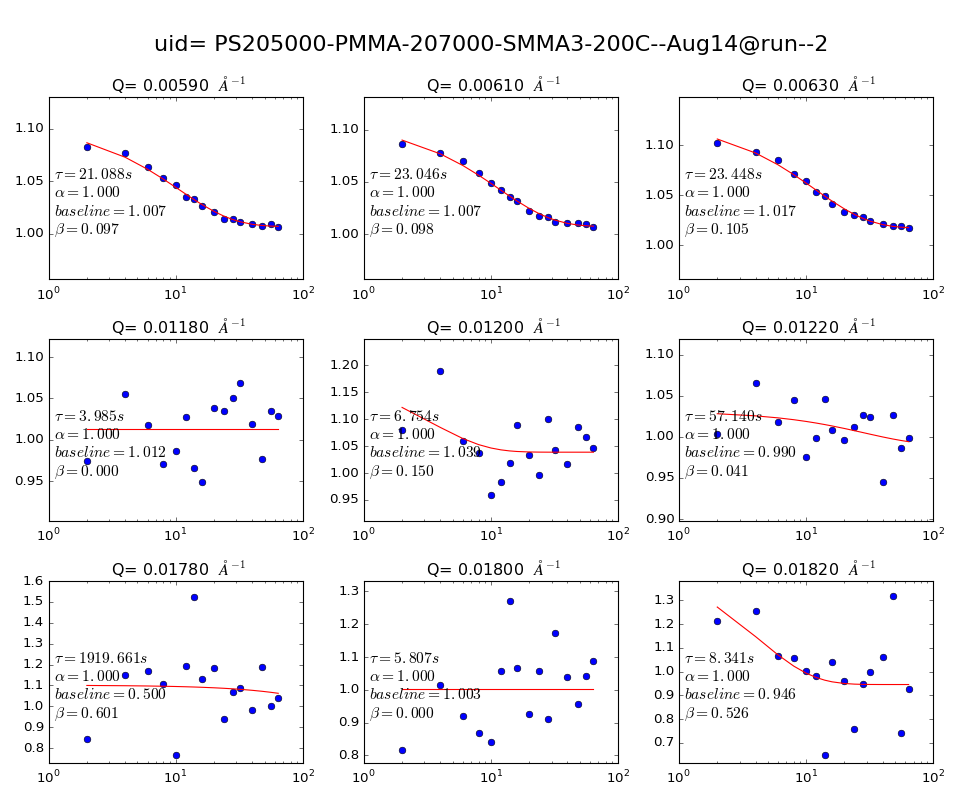

The fitted diffusion coefficient D0 is:  4.180e+02   A^2S-1


<IPython.core.display.Javascript object>


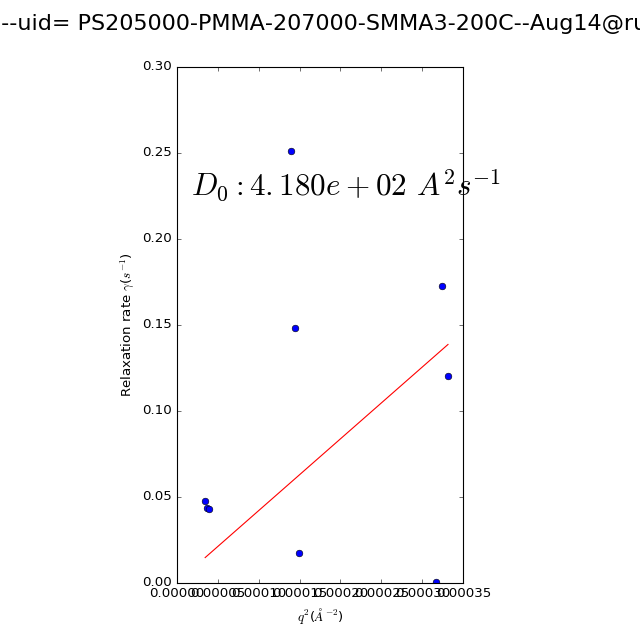

In [53]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.34,'alpha':1.0,'relaxation_rate':0.1})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center[:], fit_result['rate'][:], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [54]:
create_report = True

In [55]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [56]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=PS205000-PMMA-207000-SMMA3-200C--Aug14-average.pdf


In [57]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=PS205000-PMMA-207000-SMMA3-200C--Aug14-average.pdf
****************************************


# The End!